In [21]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, model_selection,tree, linear_model, neighbors, naive_bayes, ensemble 
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
from config import db_URI

In [22]:
engine = create_engine(db_URI)

In [23]:
# Load the viral_data.csv dataset.
viral_df = pd.read_sql_query("select *from viral_data_csv", con=engine)
viral_df = viral_df.drop(columns=['column1'])
print(viral_df.shape)
viral_df.head()

(200, 7)


,state,Year,total_pop,Uninsured_%,pc_income,gdp,Flu_%
0,Alabama,2016.0,4863525.0,9.1,39536.0,191523,0.237400
1,Alaska,2016.0,741456.0,14.0,56302.0,53289,0.143367
2,Arizona,2016.0,6941072.0,10.0,40801.0,291259,0.322227
3,Arkansas,2016.0,2989918.0,7.9,40385.0,113490,0.096424
4,California,2016.0,39167116.0,7.3,58048.0,2519133,0.112745


In [24]:
# Creating the correlation matrix
viral_df.corr()

,Year,total_pop,Uninsured_%,pc_income,gdp,Flu_%
Year,1.000000,0.005401,0.045071,0.270360,0.022074,0.320952
total_pop,0.005401,1.000000,0.191784,0.211672,0.981616,-0.144242
Uninsured_%,0.045071,0.191784,1.000000,-0.377154,0.113213,0.216051
pc_income,0.270360,0.211672,-0.377154,1.000000,0.315699,-0.085205
gdp,0.022074,0.981616,0.113213,0.315699,1.000000,-0.145826
Flu_%,0.320952,-0.144242,0.216051,-0.085205,-0.145826,1.000000


### Visualizing the data and features correlations

<Figure size 432x288 with 0 Axes>

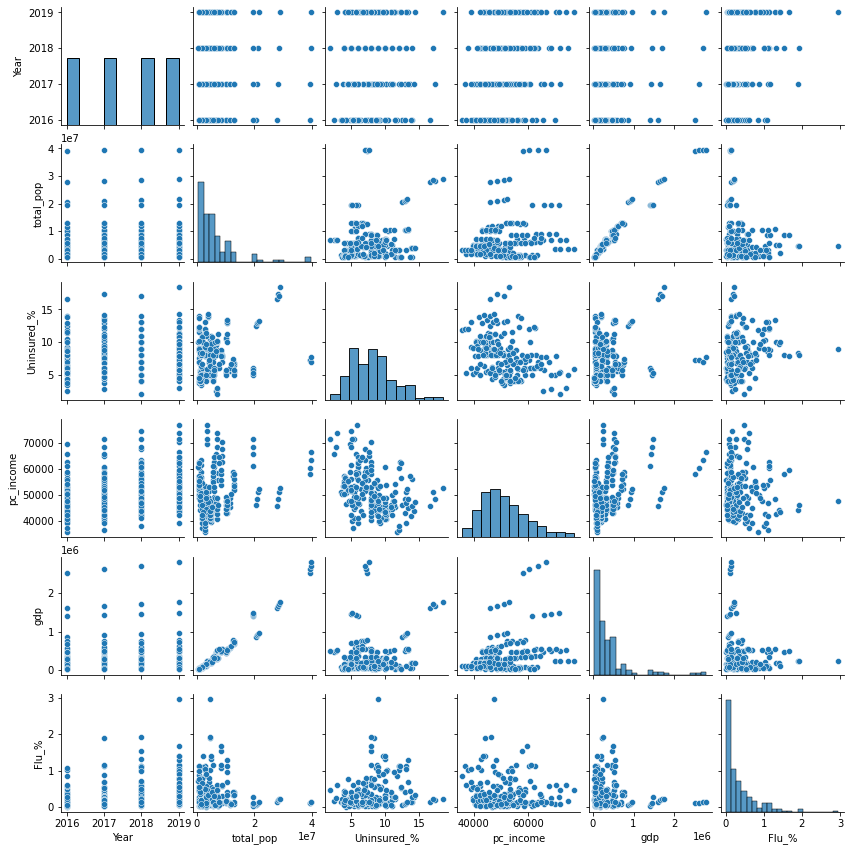

In [25]:
# Plotting a correlation matrix to visualize the flu with other features
plt.figure()
sns_plot = sns.pairplot(viral_df, height=2)

In [26]:
# Generate our categorical variable list
viral_list = viral_df.dtypes[viral_df.dtypes == "object"].index.tolist()

In [27]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(viral_df[viral_list]))
# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(viral_list)
encode_df.head()

,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,state_Delaware,state_Florida,state_Georgia,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Merge one-hot encoded features and drop the originals
viral_df = viral_df.merge(encode_df,left_index=True, right_index=True)
viral_df = viral_df.drop(viral_list,1)
print(viral_df.shape)
viral_df.head()

(200, 56)


,Year,total_pop,Uninsured_%,pc_income,gdp,Flu_%,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,2016.0,4863525.0,9.1,39536.0,191523,0.237400,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016.0,741456.0,14.0,56302.0,53289,0.143367,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016.0,6941072.0,10.0,40801.0,291259,0.322227,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016.0,2989918.0,7.9,40385.0,113490,0.096424,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016.0,39167116.0,7.3,58048.0,2519133,0.112745,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Remove flu_% target from features data
y = np.array(viral_df['Flu_%'])
X = viral_df.drop('Flu_%', axis = 1)

In [30]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [31]:
# Check dat for correctness
print('Training Features Shape:', X_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (160, 55)
Testing Features Shape: (40, 55)
Training Labels Shape: (160,)
Testing Labels Shape: (40,)


In [32]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

In [33]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
predictions

array([0.95051502, 0.12042307, 0.58035685, 0.3287263 , 0.14937064,
       0.35971263, 0.10221799, 0.3643184 , 0.3589136 , 0.90118249,
       0.23476611, 0.3414494 , 0.56659348, 0.10942455, 0.51103345,
       0.45532292, 0.15837665, 0.34656665, 0.16025253, 0.16140298,
       0.22100641, 0.22518399, 0.1833699 , 0.40929922, 0.19955046,
       0.14294539, 0.09766315, 1.38265139, 0.40701724, 0.22723915,
       0.58997498, 0.09903623, 0.19520806, 0.24009968, 0.63330954,
       0.20687228, 0.30504609, 0.20276607, 0.19934307, 0.23789585])

In [34]:
# Claculating the root mean square
from sklearn.metrics import mean_squared_error
y_true = y_test
y_pred = predictions
mean_squared_error(y_true, y_pred, squared=False)

0.2230306167432433

In [35]:
# Calculate the r-squared
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.6990872882755511

In [36]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [37]:
# Create a random forest classifier.
rf_model = RandomForestRegressor(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)

In [38]:
# Calculating the root mean error
from sklearn.metrics import mean_squared_error
y_true = y_test
mean_squared_error(y_true, y_pred, squared=False)

0.22003928553857408

In [39]:
# Calculating the root square
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.7071049608137832

In [40]:
# Plotting the residuals for the predictions vs test data
y_true-y_pred

array([ 0.22312777, -0.00900637, -0.09917602, -0.15397347, -0.01879462,
       -0.01396524,  0.02069545,  0.24519789, -0.27482076,  0.16975239,
        0.05648919,  0.62351062, -0.07225697, -0.03298952,  0.30230893,
       -0.20953684, -0.09361021, -0.05290665, -0.05222419, -0.01627717,
       -0.11146156, -0.00393981, -0.04217537, -0.25817585,  0.01404859,
       -0.03163774, -0.00619974,  0.50806701, -0.28624781,  0.05229961,
       -0.1428889 ,  0.06378743, -0.11648866, -0.21845643,  0.75428387,
       -0.06301826, -0.02279367,  0.20855543, -0.09085406, -0.06200675])

### Visualizing the correlations with seaborn

In [41]:
# Calculating the lenght of the array for plotting the y-true and y_pred
len(y_true)

40

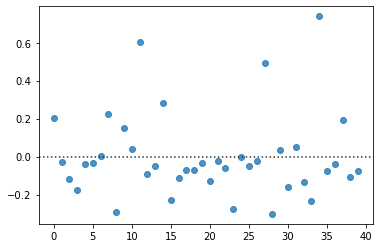

In [42]:
# Plotting the result of the regression model y_pred vs y_true (residuals)
sns.residplot(x=list(range(40)) , y=y_true-y_pred,)

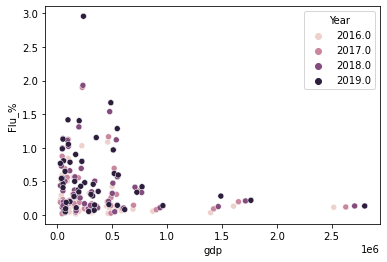

In [50]:
# Plotting individual correlation agaisnt the predicted variable "GDP vs Flu_%""
sns.scatterplot(data=viral_df, x="gdp", y="Flu_%", hue="Year")

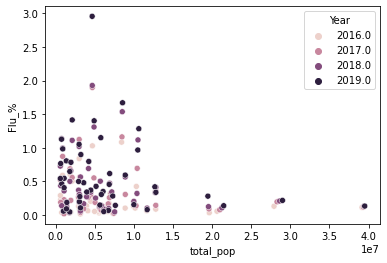

In [49]:
# Plotting individual correlation agaisnt the predicted variable "total_pop vs Flu_%""
sns.scatterplot(data=viral_df, x="total_pop",hue="Year", y="Flu_%")

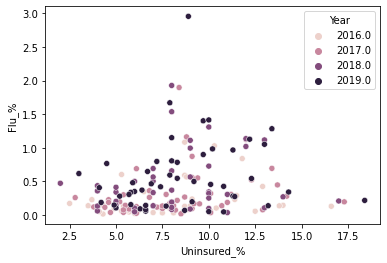

In [47]:
# Plotting individual correlation agaisnt the predicted variable "Uninsured_% vs Flu_%""
sns.scatterplot(data=viral_df, x="Uninsured_%", y="Flu_%", hue="Year")

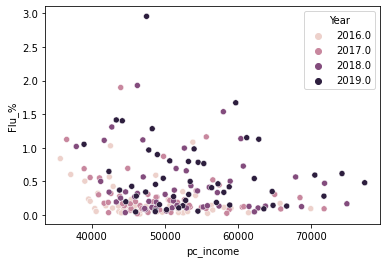

In [48]:
# Plotting individual correlation agaisnt the predicted variable "PC_Income vs Flu_%""
sns.scatterplot(data=viral_df, x="pc_income", y="Flu_%", hue="Year")